In [3]:
import numpy as np
import pandas as pd
from scipy.sparse import linalg, csc_matrix
import seaborn as sns
from matplotlib import pyplot, cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import sys

%matplotlib inline
np.set_printoptions(5,suppress=True)

In [4]:
class LidCavityFlow:
    
    def __init__(self, nx, ny, L, rho, nu, T, dt, acceleration = 4, U_top_final = 1 ):
        self.rho = rho  #densidade
        self.nu = nu    #Viscosidade
        self.T = T      #Tempo de simulação
        self.dt = dt    #Delta T
        self.nt = int(np.ceil(T/dt))
        self.mesh = Mesh(nx, ny, L)
        self.u = np.zeros((nx + 1, ny))
        self.v = np.zeros((nx, ny + 1))
        self.p = np.zeros((nx - 1, ny - 1))
        self.U_top_final = U_top_final;
        self.U_top = lambda t: t*acceleration if t*acceleration < U_top_final else U_top_final
        self.re =  int(rho*L*U_top_final/nu)
        self.errors = np.zeros(self.nt)
        self.divErrors = []
        self.U_T= []
        self.V_T= []
        self.tol=1e-7
    
    def prePross(self):
        uplot = (self.u[1:,:] + self.u[:-1,:])*0.5
        vplot = (self.v[:,1:] + self.v[:,:-1])*0.5
        self.U_L = (uplot[:,int(self.mesh.nx/2)] + uplot[:,int(self.mesh.nx/2) + 1])/2.0
        self.V_L = (vplot[int(self.mesh.ny/2),:] + vplot[int(self.mesh.ny/2) + 1,:])/2.0
        
    def buildUpB(self,u_est, v_est):
        dx, dy = self.mesh.getDxDy()
        return - (self.rho/self.dt * ( (u_est[1:-1,1:] - u_est[1:-1,:-1])/(2*dx)  + \
                                (v_est[1:,1:-1] - v_est[:-1,1:-1])/(2*dy))).copy()
    
    def plotGhia_ux(self):
        try:
            data = np.loadtxt( f'../Ghia/Re{self.re}_Ghia_ux.dat',skiprows=3)
            fig = plt.figure(figsize=(10,10))
            plt.plot(self.U_L,self.mesh.y)
            plt.plot(data[:,1], data[:,0], 'ro' ,linestyle = 'None',label= 'Ghia');
            plt.legend()
        except:
            pass
        
    def plotGhia_uy(self):
        try:
            data = np.loadtxt( f'../Ghia/Re{self.re}_Ghia_uy.dat',skiprows=3)
            fig = plt.figure(figsize=(10,10))
            plt.plot(self.V_L,self.mesh.x)
            plt.plot(data[:,1], data[:,0], 'ro' ,linestyle = 'None',label= 'Ghia');
            plt.legend()
        except:
            pass
    
    def processU_TandV_T(self,pointX=0.3,pointY=0.7):
        
        u_mean = (self.u[1:,:] + self.u[:-1,:])*0.5
        v_mean = (self.v[:,1:] + self.v[:,:-1])*0.5
        
        aux_u_t = u_mean[int(self.mesh.ny*pointX),int(self.mesh.nx*pointY)]
        aux_v_t = v_mean[int(self.mesh.ny*pointX),int(self.mesh.nx*pointY)]
        
        self.U_T.append(aux_u_t)
        self.V_T.append(aux_v_t)
        
        err = np.sqrt((aux_u_t - self.U_T[-2])**2 + (aux_v_t - self.V_T[-2])**2) if len(self.U_T) > 1 else np.inf
        
        return err
    
            
    def boudaryCond(self, u, v, it):
        
        u[:,0]  = 0
        u[:,-1] = 0
        u[-1,:] = 2 * self.U_top(it * self.dt) - u[-2,:]
        u[0,:]  = - u[1,:]
        v[0,:]  = 0
        v[-1,:] = 0
        v[:,-1] = -v[:,-2]
        v[:,0]  = -v[:,1]
        
        
    def fractionalStep(self, calcConvergencia=False):
        ustar  = self.u.copy()
        vstar  = self.v.copy()
        p_star = self.p.copy()
        dx, dy = self.mesh.getDxDy()
        nu = self.nu
        rho = self.rho
        dt = self.dt
        count = 0
        
        def calcVel(un, vn, Tn):
            uNew = un.copy()
            vNew = vn.copy()
            
            uconv = 1/(4*dx)*((un[1:-1,2:] + un[1:-1,1:-1])**2 - (un[1:-1,1:-1] + un[1:-1,:-2])**2 ) + \
                               1/(4*dy)*((un[2:,1:-1] + un[1:-1,1:-1])*(vn[1:,1:-2] + vn[1:,2:-1]) - \
                                      (un[:-2,1:-1] + un[1:-1,1:-1])*(vn[:-1,1:-2] + vn[:-1,2:-1]))

            vconv = 1/(4*dx)*((un[1:-2,1:] + un[2:-1,1:])*(vn[1:-1,1:-1] + vn[1:-1,2:]) - \
                                      (un[1:-2,:-1] + un[2:-1,:-1])*(vn[1:-1,1:-1] + vn[1:-1,:-2])) + \
                               1/(4*dy)*((vn[2:,1:-1] + vn[1:-1,1:-1])**2 - (vn[1:-1,1:-1] + vn[:-2,1:-1])**2 )

            uadv  = nu*( 1/(dx**2)*(un[1:-1,2:]-2*un[1:-1,1:-1]+un[1:-1,:-2])+\
                                    1/(dy**2)*(un[2:,1:-1]-2*un[1:-1,1:-1]+un[:-2,1:-1]))

            vadv  = nu*( 1/(dx**2)*(vn[1:-1,2:]-2*vn[1:-1,1:-1]+vn[1:-1,:-2])+\
                                    1/(dy**2)*(vn[2:,1:-1]-2*vn[1:-1,1:-1]+vn[:-2,1:-1]))

            uNew[1:-1,1:-1] = un[1:-1,1:-1] + Tn * ( - uconv + uadv - \
                                                     1/(dx*rho)*(pn[:,1:] - pn[:,:-1]) )

            vNew[1:-1,1:-1] = vn[1:-1,1:-1] + Tn * ( - vconv + vadv - \
                                                     1/(dy*rho)*(pn[1:,:] - pn[:-1,:]) )
            
            return uNew, vNew
            
        for it in range(self.nt):
            un = self.u.copy()
            vn = self.v.copy()
            pn = self.p.copy()

           
            uhalf, vhalf = calcVel(un, vn, dt/2)
            
            self.boudaryCond(uhalf, vhalf, it)
            
            ustar, vstar = calcVel(uhalf, vhalf, dt)


            b = self.buildUpB(ustar,vstar)

            p_star = linalg.spsolve(self.mesh.lOp,b.flatten()).reshape(self.mesh.nx-1, self.mesh.ny-1)

            self.u[1:-1,1:-1] = ustar[1:-1,1:-1] -  dt/(dx*rho)*(p_star[:,1:] - p_star[:,:-1])
            
            self.v[1:-1,1:-1] = vstar[1:-1,1:-1] -  dt/(dy*rho)*(p_star[1:,:] - p_star[:-1,:])
            
            self.p = pn[:] + p_star[:] 


            self.boudaryCond(self.u, self.v, it)

            div = (self.u[1:-1,1:] - self.u[1:-1,:-1])/dx + (self.v[1:,1:-1] - self.v[:-1,1:-1])/dy

            self.divErrors.append(div)

            self.errors[it] = np.abs(div).max()
            
            if(calcConvergencia):
                
                erro = self.processU_TandV_T()
                if(erro < self.tol):
                    count+=1
                    if(count > 1000):
                        break
                else:
                    count = 0

        

class Mesh:
    
    def __init__(self, nx, ny, L):
        self.nx = nx    #numero de nós D-x
        self.ny = ny    #numero de nós D-y
        self.L = L      #Comprimento da Cavidade
        self.dx = L/(nx-1)
        self.dy = L/(ny-1)
        self.x = np.linspace(0, L,nx)
        self.y = np.linspace(0, L,ny)
        self.lOp = self.LaplacianOperator()
    
    def meshGrid(self):
        return np.meshgrid(self.x,self.y)
    
    def getDxDy(self):
        return self.dx , self.dy
    
    def LaplacianOperator(self):
        dx = self.dx
        dy = self.dy
        nx = self.nx - 1
        ny = self.ny - 1
        ap = (2/dx**2 + 2/dy**2)
        ab = -1/dx**2
        L=np.zeros(( nx*ny , nx*ny ));
        for j in range(ny):
            for i in range(nx):
                L[i +( j )*nx , i +( j )*nx]= ap ;
                for ii in range(i-1,i+2, 2):
                    if ( ii >-1 and ii <nx ): 
                        L[i +( j )*nx , ii +( j  )*nx]= ab ;
                    else:
                        L[i +( j )*nx , i +( j )*nx]= L[ i +( j )*nx , i +( j )*nx] +  ab ;
                for jj in range(j-1,j+2, 2):
                    if ( jj >-1 and jj <ny ):
                        L[i +( j )*nx , i +( jj )*nx]= ab ;
                    else:
                        L[i +( j )*nx , i +( j )*nx]= L[i +( j )*nx , i +( j )*nx] +  ab ;
        return csc_matrix(L)
    

In [91]:
def plotStepEvolution(re):
    fig, ax = plt.subplots()
    a = LidCavityFlow(40,40,1,1,0.001/(re/1e3),400,0.001, 4, 1)
    a.fractionalStep(True)
    ax.plot(np.arange(len(a.U_T))*a.dt, a.U_T, label='u (m/s)')
    ax.plot(np.arange(len(a.V_T))*a.dt, a.V_T, label='v (m/s)')
    ax.set_ylabel('Velocidade', fontsize=12)
    ax.set_xlabel('t (s)', fontsize=12)
    ax.legend()
 


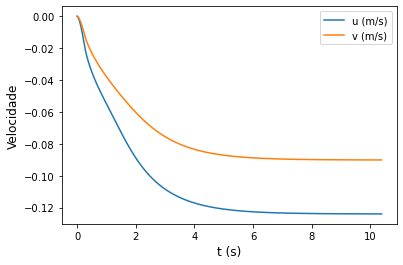

In [92]:
plotStepEvolution(100)

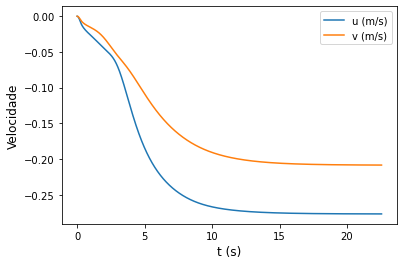

In [93]:
plotStepEvolution(400)

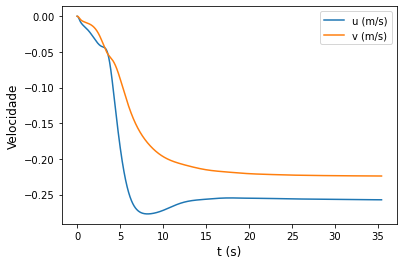

In [94]:
plotStepEvolution(1000)

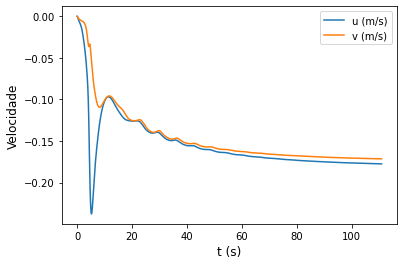

In [95]:
plotStepEvolution(3200)

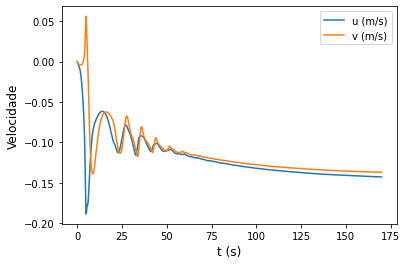

In [96]:
plotStepEvolution(5000)

In [98]:
def plotMultiMeshAndCompare(re,t,dt, mesh=[20, 40, 60, 80]):
    fig, ax = plt.subplots(ncols=2,figsize=(16,8))

    for nos in mesh:
        a = LidCavityFlow(nos,nos,1,1,0.001/(re/1e3),t ,dt, 4, 1)
        a.fractionalStep()
        a.prePross()
        U_L, V_L, x, y  = a.U_L, a.V_L, a.mesh.x, a.mesh.y
        ax[0].plot(U_L, y, label=f'Malha {nos} x {nos}')
        ax[1].plot(V_L, x, label=f'Malha {nos} x {nos}')
    
    try:
        data1 = np.loadtxt( f'../Ghia/Re{int(re)}_Ghia_ux.dat',skiprows=3)
        ax[0].plot(data1[:,1], data1[:,0], 'rs' ,linestyle = 'None',label= 'Ghia et al. (1982)');
        ax[0].set_xlabel('U(m/s)', fontsize=12)
        ax[0].set_ylabel('Y/L', fontsize=12)
        ax[0].set_title(f'Reynolds = {re}', fontsize=14)
        ax[0].legend()
    except:
        pass
    
    try:
        data2 = np.loadtxt( f'../Ghia/Re{int(re)}_Ghia_uy.dat',skiprows=3)
        ax[1].plot(data2[:,1], data2[:,0], 'rs' ,linestyle = 'None',label= 'Ghia et al. (1982)');
        ax[1].set_xlabel('V(m/s)', fontsize=12)
        ax[1].set_ylabel('X/L', fontsize=12)
        ax[1].set_title(f'Reynolds = {re}', fontsize=14)
        ax[1].legend()
    except:
        pass

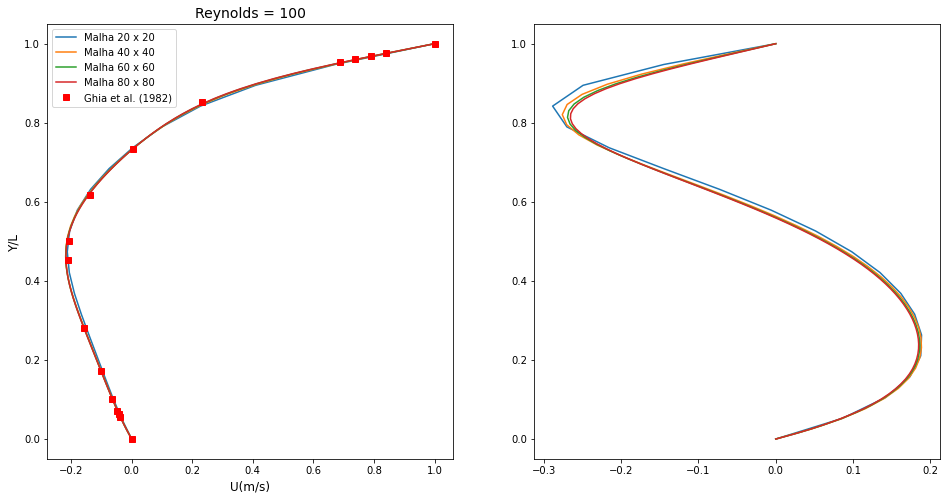

In [99]:
plotMultiMeshAndCompare(100,10,0.001)

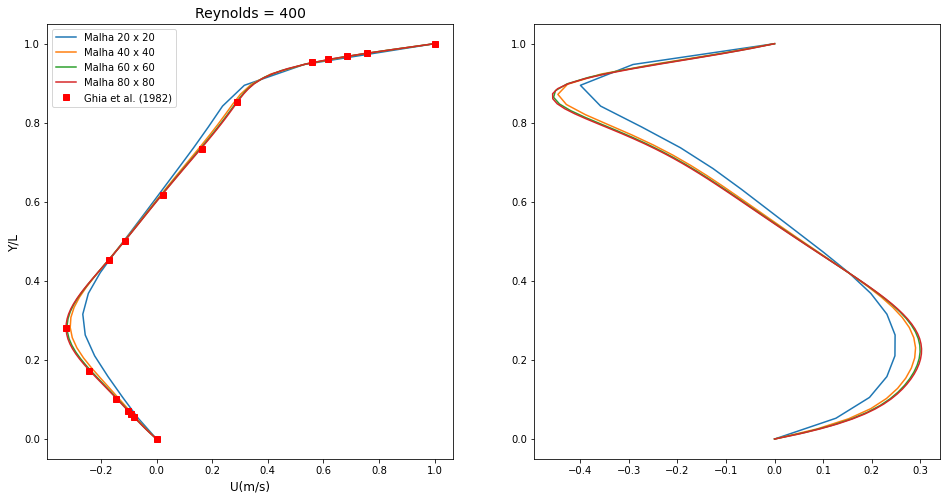

In [10]:
plotMultiMeshAndCompare(400,20,0.001)

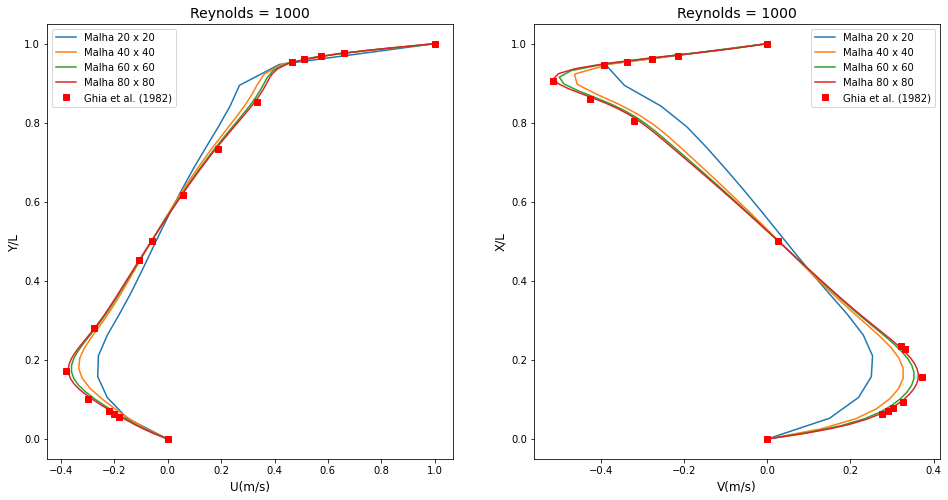

In [11]:
plotMultiMeshAndCompare(1000,30,0.001)

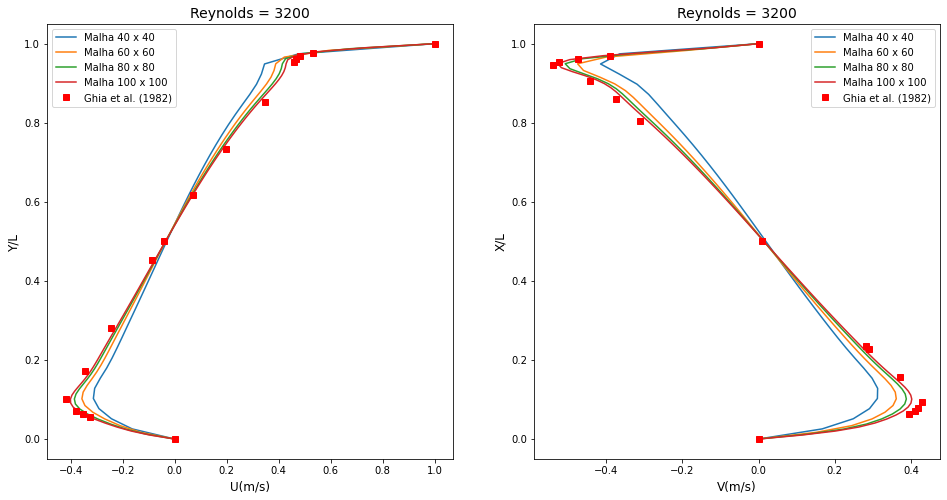

In [198]:
plotMultiMeshAndCompare(3200,100,0.001*4,mesh=[ 40, 60, 80,100])

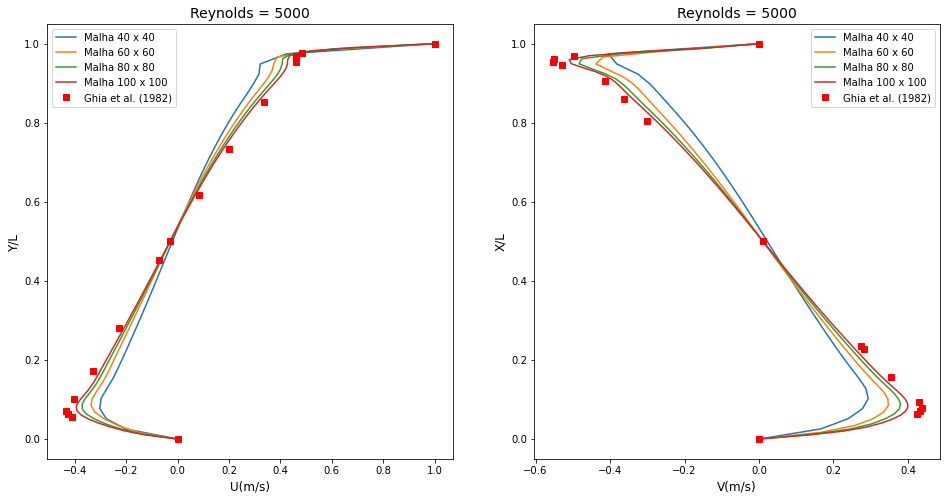

In [199]:
plotMultiMeshAndCompare(5000,160,0.001*4,mesh=[ 40, 60, 80,100])

In [97]:

def plotQuiverAndStream(nos, re=1000,t = 31, dt=6e-3):
    a = LidCavityFlow(nos,nos,1,1,0.001/(re/1e3),t ,dt, 4, 1)
    a.fractionalStep()
    a.prePross()
    
    X,Y = a.mesh.meshGrid()
    uplot = (a.u[1:,:] + a.u[:-1,:])*0.5
    vplot = (a.v[:,1:] + a.v[:,:-1])*0.5
    p = np.zeros((a.mesh.nx+1,a.mesh.ny+1))
    p[1:-1,1:-1] = a.p
    p[-1,1:-1] =a.p[-2,:]		##dp/dy = 0 en y = 
    p[0,1:-1] = a.p[1,:]	 	##dp/dy = 0 en y = 0
    p[1:-1,0]=a.p[:,1]   ##dp/dx = 0 en x = 0
    p[1:-1,-1]=a.p[:,-2]
    pc = (p[:-1,:-1] + p[1:,1:])*0.5


    fig, ax = pyplot.subplots(ncols=2,figsize=(13,5))
    ax[0].contourf(X[:,:], Y[:,:], pc,alpha=0.5)
    cs = ax[1].contourf(X[:,:], Y[:,:], pc,alpha=0.5)
    fig.colorbar(cs).ax.set_ylabel('Pressão(Pa)')
    fig.dpi=120

    ax[0].quiver(X[::3,::3], Y[::3,::3], uplot[::3,::3], vplot[::3,::3] )
    ax[0].set_title('(a)')
    ax[0].set_xlabel('X')
    ax[0].set_ylabel('Y')
    
    ax[1].streamplot(X[::2,::2], Y[::2,::2], uplot[::2,::2], vplot[::2,::2] )
    ax[1].set_title('(b)')
    ax[1].set_xlabel('X')
    ax[1].set_ylabel('Y');
    

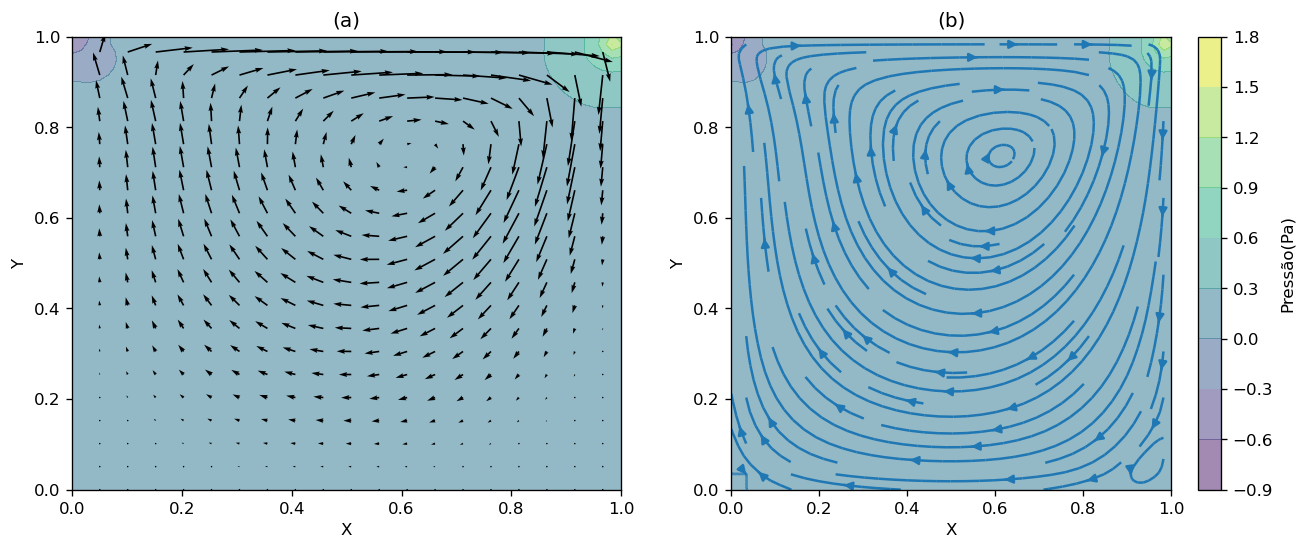

In [99]:
plotQuiverAndStream(60,re=100, t=14,dt=10e-3)

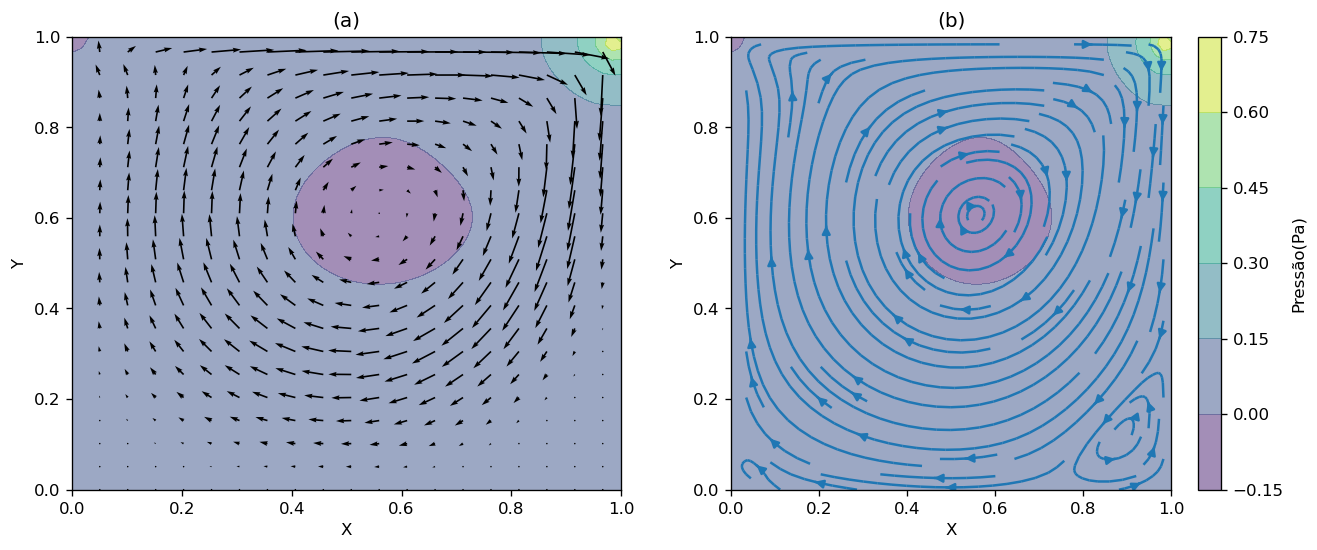

In [100]:
plotQuiverAndStream(60,re=400, t=20, dt=10e-3)

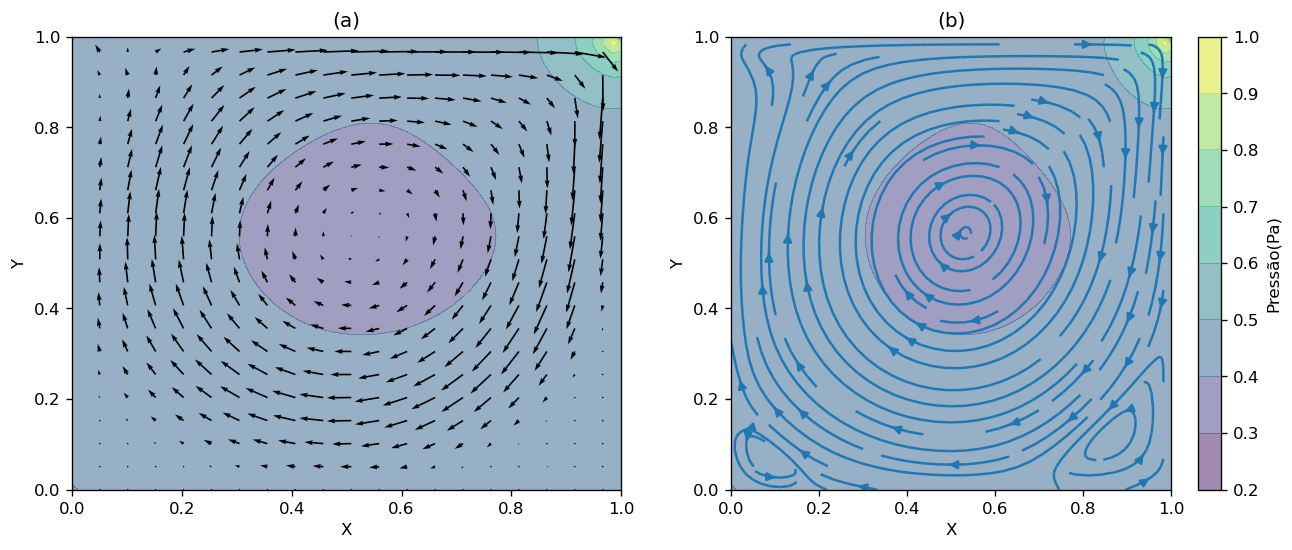

In [101]:
plotQuiverAndStream(60,re=1000, t=31)

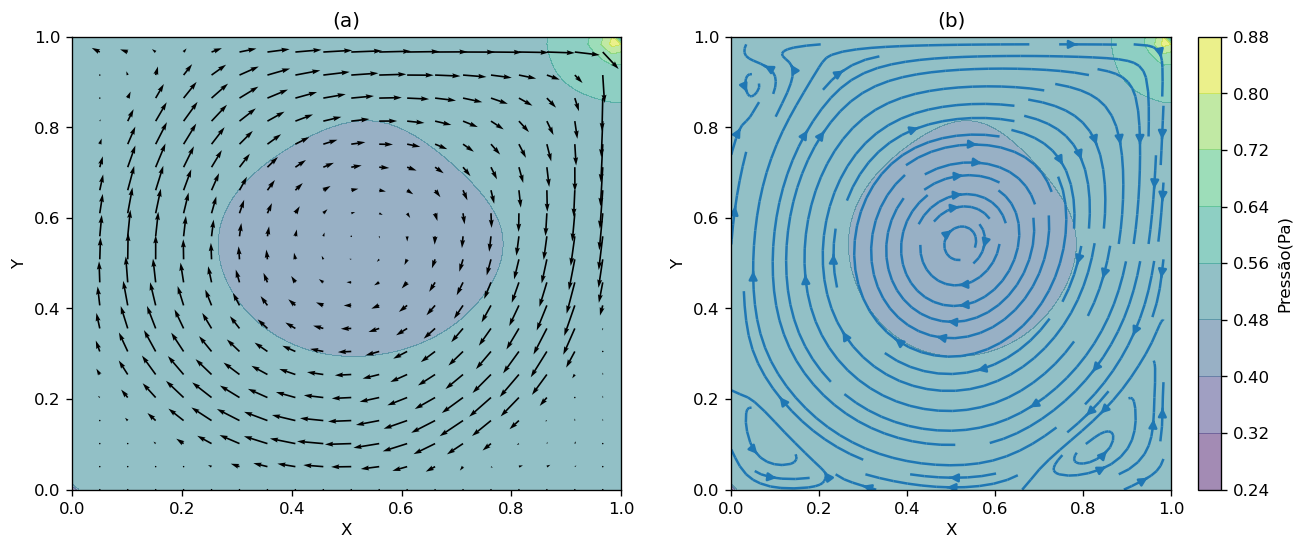

In [102]:
plotQuiverAndStream(60,re=3200, t=70,dt=6e-3)

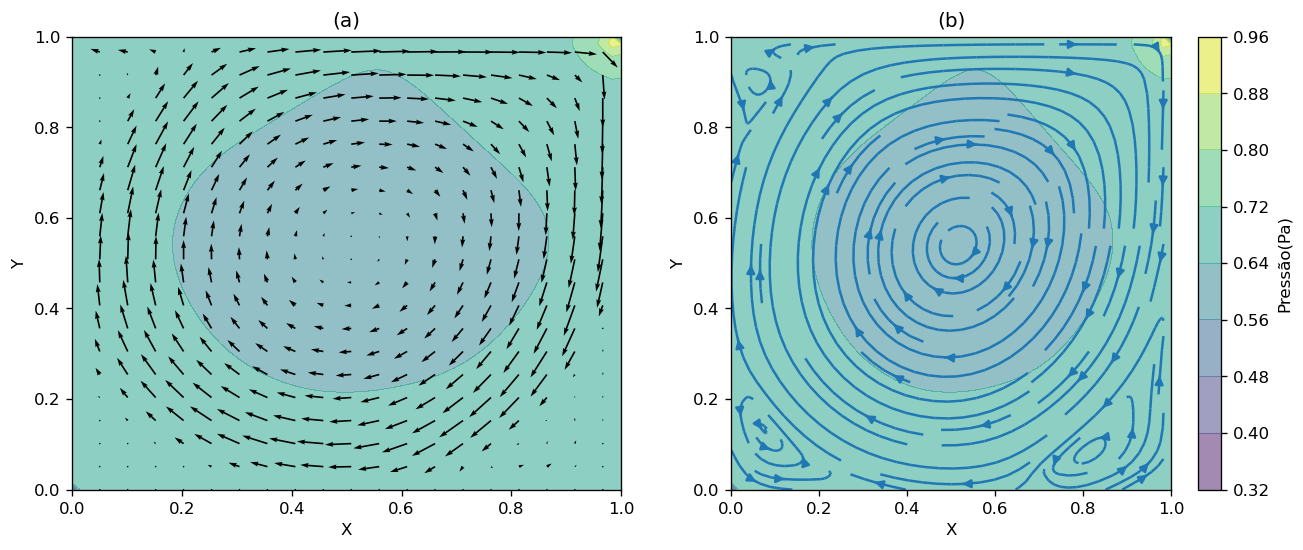

In [103]:
plotQuiverAndStream(60,re=5000, t=101,dt=6e-3)